In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')

In [2]:
bq_path = '../BrightQuery_NationalFunding_Extracts_20240118/'
bq_files = os.listdir(bq_path)
ukeys = ['bq_id', 'bq_organization_id']
# 'bq_legal_entity_id'
unique_key = 'bq_id'
col_location_dic = {'vendor_ags': ('bq_company_variables_most_recent.csv', 'bq_revenue_mr'), 'vendor_business_start_year': ('bq_company_firmographics.csv', 'bq_year_founded'), 'vendor_SIC4': ('bq_company_firmographics.csv', 'bq_sic_code'), 
              'vendor_employee_count': ('bq_company_variables_most_recent.csv','bq_current_employees_plan_mr'), 'vendor_company_type' : ('bq_company_firmographics.csv', 'bq_company_lfo'), 
              'vendor_SIC2' : ('bq_company_firmographics.csv', 'bq_sic_sector_code'), 'vendor_report_date': ('bq_company_variables_most_recent.csv','bq_report_date_mr')}
bq_nf_matched_file = '../bq_national_funding_matched.csv'
vendor_test_data_dnb = '../../vender_test_data_dnb.csv'
vendor_test_data_internal = '../../vendor_test_data_internal.csv'
#  'vendor_credit_score': ('bq_company_firmographics.csv', 'bq_score')
ags_cutoffs = [0, 100000, 500000, float('inf')]
emp_cutoffs = [0, 2, 5, float('inf')]
alt_ags_cutoffs = [0, 230000, 270000, float('inf')]
# over/under 250k bin
cutoffs_250 = [0,250000,float('inf')]
vendor = 'BrightQuery'
# days between vendor report date and NF mail date 
delta_mail_date = 120

# dictionary to rename company type in DnB comptype_hq column
comp_type_dic = {'G' : 'Proprietorship', 'H': 'Partnership', 'I' : 'Corporation', 'J' : 'Non Profit', 'O': 'Other'}
# Align NF General Non Profit status with more specific type from BQ
vendor_np_dic = {'Non-Profit Corporation' : 'Non Profit', 'Non-Profit Organization' : 'Non Profit', 'Limited Liability Company' : 'Other'}

In [3]:
def data_checker(path, ukeys, bq_nf_matched_file):
    """
    Function to evaluate missing data and identify unique keys used in vendor data files
    and a dictionary spefifying the unique key present in the file

    Args:
        path: (str) : path to files to be read / combined
        ukeys (list) : unique keys used to identify business in the files
        bq_nf_matched_file (.csv) : File of companies matching bq_id and NF unique_id 

    Returns:
        dataframe: combined dataframe containing missing value info and key uniqueness,
        dictionary specifying the unique key present in the file
    """
    files = os.listdir(path)
    bq_nf_mdf = pd.read_csv(bq_nf_matched_file, dtype={'bq_id': 'string'})
    print('csv read')
    datasources = []
    col_info = []
    unique_join_key = dict()
    for file in files:
        df= pd.read_csv(path + file, dtype={'bq_id': 'string'})
        statf = pd.DataFrame({'cols': df.columns, 'n_unique': df.apply(pd.Series.nunique), 'missing_values': df.isnull().sum()})
        file_name = file
        statf.insert(loc=0, column='file_name', value=file_name)
        statf.insert(loc=1, column = 'row_count', value=df.shape[0])
        statf.insert(loc=2, column='col_count', value = df.shape[1])
        statf[['row_count', 'col_count']] = statf[['row_count', 'col_count']].apply(pd.to_numeric)
        statf = statf.assign(missing_rate = lambda x: (x['missing_values'] / x['row_count'] * 100).round(2))
        print('missing rate calculated')
        statf['company_match_rate'] = statf.apply(lambda x: (bq_nf_mdf['bq_id'].isin(df['bq_id']).sum() / len(bq_nf_mdf)) * 100 if 'bq_id' in df.columns else 'n/a', axis=1)
        #statf['company_match_rate'] = statf.apply(lambda x: (len(bq_nf_mdf['bq_id']) - len(list(set(bq_nf_mdf['bq_id'].unique()) - set(df['bq_id'].unique()))))/ 20000 * 100 if 'bq_id' in df.columns else 'n/a',axis=1) 
        # works when 'bq_id is not string
        #statf['company_match_rate'] =  statf.apply(lambda x: (np.isin(df['bq_id'].unique(), bq_nf_mdf['bq_id'].unique()).sum() / 20000) * 100 if 'bq_id' in df.columns else 'n/a', axis=1)
        print('match_rate')
        for ukey in ukeys:
            if ukey in df.columns:
                statf[ukey + '_unique_rate'] = df[ukey].nunique()/len(df) * 100
        statf = statf.sort_values('missing_values', ascending=False)
        #clean up columns of repeated information
        filef = statf.copy()
        statf.loc[statf['file_name'].duplicated(), 'file_name'] = ''
        statf.loc[statf['row_count'].duplicated(), 'row_count'] = ''
        statf.loc[statf['col_count'].duplicated(), 'col_count'] = ''
        statf.loc[statf['company_match_rate'].duplicated(), 'company_match_rate'] = ''
        statf = statf.fillna('')

        col_info.append(filef)
        datasources.append(statf)
        unique_join_key[file] = [ukey for ukey in ukeys if ukey in list(df.columns)]
    table_stats = pd.concat(datasources)
    table_stats = table_stats.reset_index(drop=True)
    col_stats = pd.concat(col_info)
    col_stats = col_stats.reset_index(drop=True)
    col_stats.to_csv('output/data_checker.csv')

    return col_stats, unique_join_key, table_stats

In [4]:
#col_stats, unique_join_key, table_stats = data_checker(bq_path, ukeys, bq_nf_matched_file)


In [5]:
def file_matcher(path, matching_file, unique_key, col_location_dic):
    """  
    Matches desired columns from vendor files with vendor / nf match sheet

    Args
        path (str): path to the desired files to match
        matching_file (str): nf file to be matched
        unique_key (str): unique key from vendor used for matching
        col_location_dic (dict): dictionary specifying desired columns from each file
    
    Returns
        dataframe matching desired columns by unique key
    """

    table_columns = defaultdict(list)
    #dictionary pairing file name with desired columns
    for key, value in col_location_dic.items(): 
        table_columns[value[0]].append(value[1])  
    columns_ = {key: value for (key, value) in table_columns.items() if value != []}
    files = columns_.keys()
    print(files)
    matched_df = pd.read_csv(matching_file, dtype={'bq_id': 'string'})
    for file in files:
        df = pd.read_csv(path + file, dtype={'bq_id':'string' })
        cols = list(table_columns[file])
        cols.append(unique_key)
        df = df[cols]
        if not df.empty:
            matched_df = pd.merge(matched_df, df, how='left', on=[unique_key])
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].astype(str)
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].apply(lambda x: x.split(';'))
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].apply(lambda x: list(map(str.strip, x)))
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].astype(str)
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].apply(lambda x: x.split(';'))
    
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].apply(lambda x: list(map(str.strip, x)))
    return matched_df
    

In [6]:
def rename_columns(col_location_dic, matched_data):
    """
    Function to rename vendor columns

    Args:
        col_locations (dict): dictionary with column locations and corresponding column names
        df (dataframe): dataframe with columns to be renamed 

    Returns:
        dataframe with generically named vendor columns
    """
    col_rename = {}
    for key, value in col_location_dic.items():
        col_rename[value[1]] = key
    matched_data = matched_data.rename(columns=col_rename)
    return matched_data

In [7]:
def dnb_x_nf_test_data(vendor_test_data_dnb, vendor_test_data_internal):
    """
    Function to align NF test data with D&B test data

    Args
        vendor_test_data_dnb (.csv) : D&B test data spreadsheet
        vendor_test_data_internal (.csv): internal test data spreadsheet

    Returns
        test_data (dataframe) : aligned NF and D&B data with desired columns 
    """

    dnb_td = pd.read_csv(vendor_test_data_dnb, dtype={'sic4' : 'string', 'sic2': 'string'})
    internal_td = pd.read_csv(vendor_test_data_internal, dtype={'sic_code': 'string'})

    # highestcredit is not the correct column
    dnb_td = dnb_td[['unique_id', 'run_date', 'bus_strt_yr', 'gc_sales', 'gc_employees', 'sic4', 'sic2', 'highestcredit', 'comptype_hq']]
    dnb_td = dnb_td.rename(columns={'run_date': 'dnb_run_date', 'bus_strt_yr': 'dnb_business_start_year', 'gc_sales': 'dnb_ags',
                                    'gc_employees': 'dnb_employee_count', 'sic4': 'dnb_sic4', 'sic2': 'dnb_sic2', 'highestcredit': 'dnb_credit_score', 'comptype_hq': 'dnb_company_type'})
    #dnb_td['dnb_sic4'] = dnb_td['dnb_sic4'].astype(str).apply(lambda x: x.replace('.0', ''))
    #dnb_td['dnb_sic2'] = dnb_td['dnb_sic2'].astype(str).apply(lambda x: x.replace('.0',''))
    dnb_td['dnb_sic4'] = dnb_td.apply(lambda x: x['dnb_sic4'] if  pd.isnull(x['dnb_sic4']) or len(x['dnb_sic4']) == 4 else '0' + x['dnb_sic4'],axis=1)
    dnb_td['dnb_run_date'] = pd.to_datetime(dnb_td['dnb_run_date'])
    internal_td = internal_td[['unique_id', 'run_date', 'mail_date', 'company', 'credit_review_ags', 'business_start_date', 'sic_code', 'flg_type_grp']]
    internal_td = internal_td.rename(columns={'run_date': 'nf_run_date', 'mail_date': 'nf_mail_date','credit_review_ags': 'nf_ags', 'business_start_date': 'nf_business_start_year', 'sic_code': 'nf_sic4', 'flg_type_grp': 'nf_flg_type_grp'})
    internal_td['nf_business_start_year'] = pd.DatetimeIndex(internal_td['nf_business_start_year']).year
    #internal_td['nf_sic4'] = internal_td['nf_sic4'].astype(str)
    internal_td['nf_run_date'] = pd.to_datetime(internal_td['nf_run_date'])
    internal_td['nf_mail_date'] = pd.to_datetime(internal_td['nf_mail_date'])
    
    #test_data = dnb_td.merge(internal_td, on='unique_id' )
    test_data = pd.merge(internal_td, dnb_td, how='left', on='unique_id')
    return test_data

In [8]:
def nf_dnb_vendor_comps(vendor_df, dnb_nf_test_data, ags_cutoffs, emp_cutoffs, cutoffs_250, comp_type_dic, vendor_np_dic):
    """
    Function to align and compare NationalFunding, D&B, and vendor test data

    Args:
        vendor_df (dataframe) : dataframe of vendor test data
        dnb_nf_test_data (dataframe) : dataframe of combined NF and D&B data
        sales_cutoffs (list) : ranges for bins for average gross sales
        emp_cutoffs (list) : ranges for bins for average number of employees
        cutoffs_250 (list) : alternative ranges for bins for average gross sales
        comp_type_dic (dict) : dictionary for translating company type code from DnB
        vendor__np_dic (dict) : dictionary for translating company type from vendor

    Returns
        combined_df (dataframe) : dataframe with all comparison points between nf, dnb, and vendor
        nf_vendor_comp (dataframe) : dataframe comparing NF collected data with vendor data
    """
    # for Matched Columns 2 = missing data

    labels = [0,1,2]
    labelshort = [0,1]
    combined_df = dnb_nf_test_data.merge(vendor_df, on='unique_id')
    combined_df['nf_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins = ags_cutoffs, labels=labels))
    combined_df['dnb_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=ags_cutoffs, labels=labels))
    combined_df['vendor_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=ags_cutoffs, labels=labels))
    combined_df['nf_dnb_ags_bin_diff'] = combined_df['dnb_ags_bin'] - combined_df['nf_ags_bin']
    combined_df['nf_dnb_ags_per_diff'] = (combined_df['dnb_ags'] - combined_df['nf_ags']) / combined_df['nf_ags'] * 100 
    combined_df['nf_vendor_ags_bin_diff'] = combined_df['vendor_ags_bin'] - combined_df['nf_ags_bin']
    combined_df['nf_vendor_ags_per_diff'] =  (combined_df['vendor_ags'] - combined_df['nf_ags']) / combined_df['nf_ags'] * 100
    combined_df['dnb_vendor_ags_bin_diff'] = combined_df['vendor_ags_bin'] - combined_df['dnb_ags_bin']
    combined_df['dnb_vendor_ags_per_diff'] =  (combined_df['vendor_ags'] - combined_df['dnb_ags'])/combined_df['dnb_ags'] * 100
    combined_df['dnb_vendor_ags_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_bin']) or np.isnan(x['vendor_ags_bin']) else 1 if x['dnb_vendor_ags_bin_diff'] == 0 else 0, axis=1)
    combined_df['nf_vendor_ags_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['nf_ags_bin']) or np.isnan(x['vendor_ags_bin']) else 1 if x['nf_vendor_ags_bin_diff'] == 0 else 0, axis=1)
    combined_df['nf_dnb_ags_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_bin']) or np.isnan(x['nf_ags_bin']) else 1 if x['nf_dnb_ags_bin_diff'] == 0 else 0, axis=1)

    #bins matched / not matched
    # combined_df['nf_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins=alt_ags_cutoffs, labels=labels))
    # combined_df['dnb_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=alt_ags_cutoffs, labels=labels))
    # combined_df['vendor_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=alt_ags_cutoffs,labels=labels))
    # combined_df['dnb_vendor_ags_250_bin_diff'] = combined_df['vendor_ags_250_bin'] - combined_df['dnb_ags_250_bin']
    # combined_df['nf_vendor_ags_250_bin_diff'] = combined_df['vendor_ags_250_bin'] - combined_df['nf_ags_250_bin']
    
    combined_df['nf_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins=cutoffs_250, labels=labelshort))
    combined_df['dnb_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=cutoffs_250, labels=labelshort))
    combined_df['vendor_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=cutoffs_250,labels=labelshort))
    combined_df['dnb_vendor_ags_ou_250_bin_diff'] = combined_df['vendor_ags_ou_250_bin'] - combined_df['dnb_ags_ou_250_bin']
    combined_df['nf_vendor_ags_ou_250_bin_diff'] = combined_df['vendor_ags_ou_250_bin'] - combined_df['nf_ags_ou_250_bin']
    combined_df['dnb_vendor_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_ou_250_bin']) or np.isnan(x['vendor_ags_ou_250_bin']) else 1 if x['dnb_vendor_ags_ou_250_bin_diff'] == 0 else 0, axis=1)
    combined_df['nf_vendor_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['nf_ags_ou_250_bin']) or np.isnan(x['vendor_ags_ou_250_bin']) else 1 if x['nf_vendor_ags_ou_250_bin_diff'] == 0 else 0, axis=1)
    combined_df['nf_dnb_ags_ou_250_bin_diff'] = combined_df['dnb_ags_ou_250_bin'] - combined_df['nf_ags_ou_250_bin']
    combined_df['nf_dnb_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_ou_250_bin']) or np.isnan(x['nf_ags_ou_250_bin']) else 1 if x['nf_dnb_ags_ou_250_bin_diff'] == 0 else 0, axis=1)


    # make percent diff?
    combined_df['nf_dnb_start_year_diff'] = combined_df['dnb_business_start_year'] - combined_df['nf_business_start_year']
    combined_df['nf_vendor_start_year_diff'] = combined_df['vendor_business_start_year'] - combined_df['nf_business_start_year']
    combined_df['dnb_vendor_start_year_diff'] = combined_df['vendor_business_start_year'] -  combined_df['dnb_business_start_year']

    combined_df['dnb_vendor_sy_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_business_start_year']) or np.isnan(x['vendor_business_start_year']) else 1 if x['dnb_vendor_start_year_diff'] == 0 else 0, axis=1)
    combined_df['nf_vendor_sy_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['nf_business_start_year']) or np.isnan(x['vendor_business_start_year']) else 1 if x['nf_vendor_start_year_diff'] == 0 else 0, axis=1)
    combined_df['nf_dnb_sy_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_business_start_year']) or np.isnan(x['nf_business_start_year']) else 1 if x['nf_dnb_start_year_diff'] == 0 else 0, axis=1)

    combined_df = combined_df.replace({'dnb_company_type': comp_type_dic, 'vendor_company_type': vendor_np_dic})
    #combined_df['dnb_company_type'] = combined_df['dnb_company_type'].fillna('Other')
    combined_df['dnb_vendor_company_type_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_company_type']) or pd.isnull(x['vendor_company_type']) else 1 if x['dnb_company_type'] == x['vendor_company_type'] else 0, axis=1)
    
    # Creating 2 digit NF SIC codes from 4 digit SIC2
    combined_df['nf_sic2'] = combined_df['nf_sic4'].str.slice(0,2)

    #does indicating columns matter for .apply?
    
    #BQ does not have any missing SIC4
    # combined_df['nf_vendor_sic4_match'] = combined_df[['nf_sic4', 'vendor_SIC4']].apply(lambda x: 2 if x['nf_sic4'] == 'NA' or x['vendor_SIC4'] == 'NA' else 1 if x['nf_sic4'] in x['vendor_SIC4'] else 0, axis=1) 
    combined_df['nf_vendor_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic4']) else 1 if x['nf_sic4'] in x['vendor_SIC4'] else 0, axis=1) 
    #pd.isnull(x['vendor_SIC4'])
    combined_df['nf_vendor_sic2_match'] = combined_df.apply(lambda x:  2 if pd.isnull(x['nf_sic2']) else 1 if x['nf_sic2'] in x['vendor_SIC2'] else 0, axis=1)
    combined_df['dnb_vendor_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_sic4']) else  1 if x['dnb_sic4'] in x['vendor_SIC4'] else 0, axis=1)
    combined_df['dnb_vendor_sic2_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_sic2']) else  1 if x['dnb_sic2'] in x['vendor_SIC2'] else 0, axis=1)

    combined_df['nf_dnb_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic4']) or pd.isnull(x['dnb_sic4']) else  1 if x['nf_sic4'] == x['dnb_sic4'] else 0, axis=1)
    combined_df['nf_dnb_sic2_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic2']) or pd.isnull(x['dnb_sic2']) else  1 if x['nf_sic2'] == x['dnb_sic2'] else 0, axis=1)

    # time delta between vendor report time and NF mail date
    combined_df['vendor_report_date'] = pd.to_datetime(combined_df['vendor_report_date'])
    combined_df['days_from_mail_date'] = combined_df['vendor_report_date'] - combined_df['nf_mail_date']
    
    nf_vendor_comp_df = combined_df.dropna(subset = ['nf_ags'])
    nf_vendor_comp_df = nf_vendor_comp_df.reset_index(drop=True)
    
    combined_df['dnb_emp_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_employee_count'], bins=emp_cutoffs, labels=labels))
    combined_df['vendor_emp_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_employee_count'], bins=emp_cutoffs, labels=labels))
    combined_df['dnb_vendor_emp_bin_diff'] = combined_df['vendor_emp_bin'] - combined_df['dnb_emp_bin']
    combined_df['dnb_vendor_emp_per_diff'] = (combined_df['vendor_employee_count'] - combined_df['dnb_employee_count']) / combined_df['dnb_employee_count'] * 100
    combined_df['dnb_vendor_emp_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_emp_bin']) or np.isnan(x['vendor_emp_bin']) else 1 if x['dnb_vendor_emp_bin_diff'] == 0 else 0, axis=1)
 
    combined_df.to_csv('output/nf_dnb_vendor_comp.csv')
    nf_vendor_comp_df.to_csv('output/nf_vendor_comp.csv')

    dnb_compdf = combined_df
    nf_compdf = nf_vendor_comp_df
    # midnfmask = (nf_compdf['nf_ags_250_bin'] == 1)
    # nfven250 = nf_compdf[midnfmask]
    # middnbmask =(dnb_compdf['dnb_ags_250_bin'] == 1)
    # dnbven250 = dnb_compdf[middnbmask]
    return dnb_compdf, nf_vendor_comp_df#, dnbven250, nfven250

In [9]:
col_stats, unique_join_key, table_stats = data_checker(bq_path, ukeys, bq_nf_matched_file)
matched_data = file_matcher(bq_path, bq_nf_matched_file, unique_key, col_location_dic)
matched_data = rename_columns(col_location_dic, matched_data)
dnb_nf_test_data = dnb_x_nf_test_data(vendor_test_data_dnb, vendor_test_data_internal)
dnb_compdf, nf_compdf = nf_dnb_vendor_comps(matched_data, dnb_nf_test_data, ags_cutoffs, emp_cutoffs, cutoffs_250, comp_type_dic, vendor_np_dic)

csv read


missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
dict_keys(['bq_company_variables_most_recent.csv', 'bq_company_firmographics.csv'])


In [10]:
df = nf_compdf[['bq_id', 'nf_sic4', 'nf_sic2', 'nf_run_date', 'vendor_SIC4', 'vendor_SIC2', 'nf_vendor_sic4_match']]

In [11]:
df.head()

,bq_id,nf_sic4,nf_sic2,nf_run_date,vendor_SIC4,vendor_SIC2,nf_vendor_sic4_match
0,100000676802,<NA>,<NA>,2022-08-01,"[1711, 1791, 1796, 7699]","[17, 76]",2
1,100037166351,5093,50,2021-12-01,[7538],[75],0
2,100022846905,7538,75,2022-07-01,[8111],[81],0
3,100007940897,0782,07,2022-10-01,"[0782, 0783]",[07],1
4,100035682826,4213,42,2022-10-01,[7532],[75],0


In [12]:
# 100000676802 null sic4
# 100037166351	not null
df.loc[df['bq_id'] == '100037166351', ['nf_sic4']].isna()

,nf_sic4
1,False


In [13]:
def table_info(table_stats):
    table_stats = table_stats[['file_name', 'row_count', 'col_count', 'company_match_rate', 'bq_id_unique_rate', 'bq_organization_id_unique_rate']]
    file_mask = (table_stats['file_name'] != '')
    display(table_stats[file_mask].reset_index(drop=True))

In [14]:
def top_10_by_file(col_stats):
    col_stats = col_stats[['file_name','cols','missing_rate']]
    files = col_stats['file_name'].unique()
    for file in files:
        file_mask = (col_stats['file_name'] == file)
        #col_stats.style.set_caption(file)
        display(col_stats[file_mask].drop(columns=['file_name']).head(10).style.set_caption(file).format({'missing_rate' : '{:.2f}'}).hide())

In [15]:
def dnb_ven_ags_charts(dnb_compdf, ags_cutoffs, alt_ags_cutoffs, vendor, cutoffs_250):

    color5 = ['red', 'red', 'green', 'red', 'red']
    color3 = ['red', 'green', 'red']
    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))
    #narrow histogram from outliers
    lower_outbound = (dnb_compdf['dnb_vendor_ags_per_diff'] >=-500)
    upper_outbound = (dnb_compdf['dnb_vendor_ags_per_diff'] <= 500)
    out_mask = lower_outbound & upper_outbound
    # df for histogram
    dnb_compdflim = dnb_compdf[out_mask]

    fig = plt.figure(figsize=(16,12),layout='constrained')
    gs = GridSpec(4, 2, figure=fig)
    fig.suptitle('DnB vs {} AGS Data'.format(vendor), fontsize='xx-large')

    # ax1 = fig.add_subplot(gs[0, 0])
    # round(dnb_compdf['dnb_vendor_ags_250_bin_diff'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_ags_250_bin_diff'])*100,2).plot(ax=ax1, kind='bar', color=color)
    # ax1.set_title('{} < {} < {} < {}'.format(*alt_ags_cutoffs))
    # ax1.bar_label(ax1.containers[0])
    # ax1.set_ylabel('%')
    # t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_ags_250_bin_diff']))
    # ax1.text(.85,.95,t1,transform=ax1.transAxes)
    # ax1.set_ylim(0,100)

    ax1 = fig.add_subplot(gs[0,0])
    round(dnb_compdf['dnb_vendor_ags_bin_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_ags_bin_match'])*100,2).plot(ax=ax1, kind='bar', color=color2)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*ags_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_ags_bin_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    # adjust share y based on chart with tallest bar?
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    round(dnb_compdf['dnb_vendor_ags_bin_diff'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_ags_bin_diff'])*100, 2).plot(ax=ax2, kind='bar', color=color5)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*ags_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_ags_bin_diff']))
    ax2.text(.85,.95,t2, transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    # ax3 = fig.add_subplot(gs[1,0], sharey=ax2)
    # round(dnbven250['dnb_vendor_ags_250_bin_diff'].value_counts().sort_index()/len(dnbven250['dnb_vendor_ags_250_bin_diff'])*100,2).plot(ax=ax3, kind='bar')
    # ax3.set_title('{} - {} Bin Difference'.format(*alt_ags_cutoffs[1:3]))
    # ax3.bar_label(ax3.containers[0])
    # ax3.set_ylabel('%')
    # t3 = 'n = {}'.format(len(dnbven250['dnb_vendor_ags_250_bin_diff']))
    # ax3.text(.85,.95,t3, transform=ax3.transAxes)
    # ax3.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(dnb_compdf['dnb_vendor_ags_ou_250_bin_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_ags_ou_250_bin_match'])*100,2).plot(ax=ax3, kind='bar', color=color2)
    ax3.set_title('{} < {} < {} Bin Match Rate'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_ags_ou_250_bin_match']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(dnb_compdf['dnb_vendor_ags_ou_250_bin_diff'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_ags_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_ags_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)

    ax5 = fig.add_subplot(gs[2:, :])
    ax5.set_title('% Differnce in AGS')
    values, bins, bars = ax5.hist(dnb_compdflim['dnb_vendor_ags_per_diff'], bins=50)
    ax5.bar_label(bars, size=9)
    ax5.set_ylabel('Count')
    t5 = 'n = {}\n{} values > 500%\n0 values < -100%\n\nExcluding Those Outliers:'.format(len(dnb_compdf['dnb_vendor_ags_per_diff']),(len(dnb_compdf[~upper_outbound]))- dnb_compdf['vendor_ags'].isnull().sum())
    ax5.axvline(x=0, color='white',ls='-',lw=1)
    ax5.axvline(x=dnb_compdflim['dnb_vendor_ags_per_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(dnb_compdflim['dnb_vendor_ags_per_diff'].median(),2)))
    ax5.axvline(x=dnb_compdflim['dnb_vendor_ags_per_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {}%'.format(round(dnb_compdflim['dnb_vendor_ags_per_diff'].mean(), 2)))
    ax5.legend(loc='upper right', title=t5)
    
    plt.show()

In [16]:
def nf_vendor_ags_charts(nf_compdf, ags_cutoffs, alt_ags_cutoffs, vendor):

    color5 = ['red', 'red', 'green', 'red', 'red']
    color3 = ['red', 'green', 'red']
    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))
    #filter outliers
    lower_outbound = (nf_compdf['nf_vendor_ags_per_diff'] >=-500)
    upper_outbound = (nf_compdf['nf_vendor_ags_per_diff'] <= 500)
    out_mask = lower_outbound & upper_outbound
    # df for histogram
    nf_compdflim = nf_compdf[out_mask]

    fig = plt.figure(figsize=(16,12), layout='constrained')
    gs = GridSpec(4,2,figure=fig)
    fig.suptitle('NF vs {} AGS Data'.format(vendor), fontsize='xx-large')

    # ax1= fig.add_subplot(gs[0,0])
    # round(nf_compdf['nf_vendor_ags_250_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_250_bin_diff'])*100,2).plot(ax=ax1, kind='bar',color=color)
    # ax1.set_title('{} < {} < {} < {}'.format(*alt_ags_cutoffs))
    # ax1.bar_label(ax1.containers[0])
    # ax1.set_ylabel('%')
    # t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_bin_diff']))
    # ax1.text(.85, .95, t1, ha='left', transform=ax1.transAxes)
    # ax1.set_ylabel('%')
    # ax1.set_ylim(0,100)

    ax1 = fig.add_subplot(gs[0,0])
    round(nf_compdf['nf_vendor_ags_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_bin_match'])*100,2).plot(ax=ax1, kind='bar', color=color2)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*ags_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_bin_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    round(nf_compdf['nf_vendor_ags_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_bin_diff'])*100,2).plot(ax=ax2, kind='bar', color=color5)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*ags_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_bin_diff']))
    ax2.text(.85, .95, t2, ha='left', transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    # ax3 = fig.add_subplot(gs[1,0])
    # round(nfven250['nf_vendor_ags_250_bin_diff'].value_counts().sort_index()/len(nfven250['nf_vendor_ags_250_bin_diff'])*100,2).plot(ax=ax3, kind='bar')
    # ax3.set_title('{} - {} Bin Difference'.format(*alt_ags_cutoffs[1:3]))
    # ax3.bar_label(ax3.containers[0])
    # t3 = 'n = {}'.format(len(nfven250['nf_vendor_ags_250_bin_diff']))
    # ax3.text(.85, .95, t3, ha='left', transform=ax3.transAxes)
    # ax3.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(nf_compdf['nf_vendor_ags_ou_250_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_ou_250_bin_match'])*100,2).plot(ax=ax3, kind='bar', color=color2)
    ax3.set_title('{} < {} < {} Bin Match Rate'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_ou_250_bin_match']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(nf_compdf['nf_vendor_ags_ou_250_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)


    ax5 = fig.add_subplot(gs[2:, :])
    ax5.set_title('% Difference in AGS')
    values, bins, bars = ax5.hist(nf_compdflim['nf_vendor_ags_per_diff'], bins=50)
    ax5.bar_label(bars, size=9)
    ax5.set_ylabel('Count')
    t4 = 'n = {}\n{} values > 500%\n0 values < -100%\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_vendor_ags_per_diff']), len(nf_compdf[~upper_outbound]) -  nf_compdf['vendor_ags'].isnull().sum())
    ax5.axvline(x=0, color='white',ls='-',lw=1)
    ax5.axvline(x=nf_compdflim['nf_vendor_ags_per_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(nf_compdflim['nf_vendor_ags_per_diff'].median(),2)))
    ax5.axvline(x=nf_compdflim['nf_vendor_ags_per_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}%'.format(round(nf_compdflim['nf_vendor_ags_per_diff'].mean(), 2)))
    ax5.legend(loc='upper right', title=t4)

    plt.show()

In [17]:
def dnb_ven_emp_charts(dnb_compdf, emp_cutoffs):

    color5 = ['red', 'red', 'green', 'red', 'red']
    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))
    #filter outliers at start?
    lower_outbound = (dnb_compdf['dnb_vendor_emp_per_diff'] >=-100)
    upper_outbound = (dnb_compdf['dnb_vendor_emp_per_diff'] <= 100)
    out_mask = lower_outbound & upper_outbound
    # df for histogram filtering Outliers
    dnb_compdflim = dnb_compdf[out_mask]

    fig = plt.figure(figsize=(12,9), layout='constrained')
    gs = GridSpec(2, 2, figure=fig)
    fig.suptitle('DnB vs Vendor Employee Differential', fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    round(dnb_compdf['dnb_vendor_emp_bin_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_emp_bin_match'])*100,2).plot(ax=ax1, kind='bar', color=color2)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*emp_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_emp_bin_match']))
    ax1.text(.85, .95, t1, ha='left', transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    round(dnb_compdf['dnb_vendor_emp_bin_diff'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_emp_bin_diff'])*100,2).plot(ax=ax2, kind='bar',color=color5)
    ax2.set_title('{} < {} < {} < {} Bin Differential'.format(*emp_cutoffs))
    ax2.bar_label(ax2.containers[0])
    ax2.set_ylabel('%')
    t2 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_emp_bin_diff']))
    ax2.text(.85, .95, t2, ha='left', transform=ax2.transAxes)
    ax2.set_ylim(0, 100)

    ax3 = fig.add_subplot(gs[1:, :])
    ulim = 100
    llim = -100
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=4)
    values, bins, bars = ax3.hist(dnb_compdflim['dnb_vendor_emp_per_diff'], bins=bins)
    ax3.bar_label(bars, size=9)
    ax3.set_ylabel('Count')

    #outliers without missing values
    dnb_compdf_nona = dnb_compdf.dropna(subset=['vendor_employee_count'])
    t3 = 'n = {}\n{} values > 100%\n{} values < -100%\n\nExcluding Those Outliers:'.format(len(dnb_compdf['dnb_vendor_emp_per_diff']), len(dnb_compdf_nona[~upper_outbound]),len(dnb_compdf_nona[~lower_outbound]))
    ax3.axvline(x=0, color='white',ls='--',lw=1)
    ax3.axvline(x=dnb_compdflim['dnb_vendor_emp_per_diff'].median(), color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(dnb_compdflim['dnb_vendor_emp_per_diff'].median(),2)))
    ax3.axvline(x=dnb_compdflim['dnb_vendor_emp_per_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {}%'.format(round(dnb_compdflim['dnb_vendor_emp_per_diff'].mean(),2)))
    ax3.legend(loc='upper right', title=t3)

    plt.show()


In [18]:
def dnb_vendor_bsy_charts(dnb_compdf, vendor):
    color = ['red' , 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(20,12), layout='constrained')
    gs = GridSpec(6,3, figure=fig)
    fig.suptitle('DnB vs {} Business Start Year Comparison'.format(vendor), fontsize='xx-large')

    # mask for outliers on hist
    ulim = 25
    llim = -25
    upper_outbound = (dnb_compdf['dnb_vendor_start_year_diff'] < ulim)
    lower_outbound = (dnb_compdf['dnb_vendor_start_year_diff'] > llim)
    outmask = lower_outbound & upper_outbound
    # df for histogram
    dnb_compdflim = dnb_compdf[outmask]

    # dnb_vendor_sy_match
    ax1 = fig.add_subplot(gs[0:2,0])
    round(dnb_compdf['dnb_vendor_sy_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_sy_match'])*100,2).plot(ax=ax1, kind='bar',color=color)
    ax1.set_title('Business Start Year Match')
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_sy_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0:2,1:])
    ax2.set_title('Business Start Year Difference')
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=1)
    values, bins, bars = ax2.hist(dnb_compdflim['dnb_vendor_start_year_diff'], bins=bins)
    ax2.bar_label(bars, size=8)
    ax2.axvline(x=0, color='white',ls='--',lw=1)
    ax2.axvline(x=dnb_compdflim['dnb_vendor_start_year_diff'].median(), color='red', ls='dotted', lw=2, label='Median = {} years'.format(round(dnb_compdflim['dnb_vendor_start_year_diff'].median(),2)))
    ax2.axvline(x=dnb_compdflim['dnb_vendor_start_year_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {} years'.format(round(dnb_compdflim['dnb_vendor_start_year_diff'].mean(),2)))
    #outliers without missing values
    dnb_compdf_nona = dnb_compdf.dropna(subset=['vendor_business_start_year'])
    t5 = 'n = {}\n{} values < -25 years\n{} values > 25 years\n\nExcluding Those Outliers:'.format(len(dnb_compdf['dnb_vendor_start_year_diff']), len(dnb_compdf_nona[~lower_outbound]), len(dnb_compdf_nona[~upper_outbound]))
    ax2.legend(loc='upper right', title=t5)
    
    plt.show()
    

In [19]:
def dnb_vendor_sic_charts(dnb_compdf, vendor):

    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))


    fig = plt.figure(figsize=(6,8), layout='constrained')
    gs = GridSpec(2,1, figure=fig)
    fig.suptitle('DnB vs {} SIC Code Comparison'.format(vendor), fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('SIC4 Match Rate')
    round(dnb_compdf['dnb_vendor_sic4_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_sic4_match'])*100, 2).plot(ax=ax1, kind='bar', color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_sic4_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('SIC2 Match Rate')
    round(dnb_compdf['dnb_vendor_sic2_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_sic2_match'])*100, 2).plot(ax=ax2, kind='bar', color=color2)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_sic2_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    plt.show()
    

In [20]:
def dnb_vendor_company_type_charts(dnb_compdf, vendor):

    color3 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(6,8), layout='constrained')
    gs = GridSpec(2,1, figure=fig)
    fig.suptitle('DnB vs {} Company Type Comparison'.format(vendor), fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('Company Type Match Rate')
    round(dnb_compdf['dnb_vendor_company_type_match'].value_counts().sort_index()/len(dnb_compdf['dnb_vendor_company_type_match'])* 100, 2).plot(ax=ax1, kind='bar', color=color3)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(dnb_compdf['dnb_vendor_company_type_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    plt.show()

In [21]:
def nf_vendor_bsy_charts(nf_compdf, vendor):

    color2 = ['red' , 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(20,12), layout='constrained')
    gs = GridSpec(6,3, figure=fig)
    fig.suptitle('NF vs {} Business Start Year Comparison'.format(vendor), fontsize='xx-large')

    ulim = 25
    llim = -25
    # Mask for Outliers
    lower_sy_bound = (nf_compdf['nf_vendor_start_year_diff'] > llim)
    upper_sy_bound = (nf_compdf['nf_vendor_start_year_diff'] < ulim)
    sy_mask = lower_sy_bound & upper_sy_bound 
    nf_compdflim = nf_compdf[sy_mask]
    
    ax1 = fig.add_subplot(gs[0:2,0])
    round(nf_compdf['nf_vendor_sy_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sy_match'])*100, 2).plot(ax=ax1, kind='bar',color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_title('Business Start Year Match')
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_sy_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0, 100)


    ax2 = fig.add_subplot(gs[0:2,1:])
    ax2.set_title('Business Start Year Difference')
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=1)
    values, bins, bars = ax2.hist(nf_compdflim['nf_vendor_start_year_diff'], bins=bins)
    ax2.bar_label(bars, size=8)
    ax2.axvline(x=nf_compdflim['nf_vendor_start_year_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}years'.format(round(nf_compdflim['nf_vendor_start_year_diff'].median(),2)))
    ax2.axvline(x=nf_compdflim['nf_vendor_start_year_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}years'.format(round(nf_compdflim['nf_vendor_start_year_diff'].mean(), 2)))
    #outliers without missing values
    nf_compdf_nona = nf_compdf.dropna(subset=['vendor_business_start_year'])
    t5 = 'n = {}\n{} values < -25 years\n{} values > 25 years\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_vendor_start_year_diff']), len(nf_compdf_nona[~lower_sy_bound]), len(nf_compdf_nona[~upper_sy_bound]))
    ax2.legend(loc='upper right', title=t5)
    
    plt.show()
    

In [22]:
def nf_vendor_sic_charts(nf_compdf, vendor):

    color2 = ['red', 'green', 'Black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))
    
    fig = plt.figure(figsize=(6,8), layout='constrained')
    gs = GridSpec(2,1,figure=fig)
    fig.suptitle('NF vs {} SIC Code Comparison'.format(vendor), fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('SIC4 Match Rate')
    round(nf_compdf['nf_vendor_sic4_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sic4_match'])*100, 2).plot(ax=ax1, kind='bar', color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_sic4_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('SIC2 Match Rate')
    round(nf_compdf['nf_vendor_sic2_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sic2_match'])*100, 2).plot(ax=ax2, kind='bar', color=color2)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(nf_compdf['nf_vendor_sic2_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    plt.show()


In [23]:
# using nf_compdf to only compare on submissions
def nf_dnb_ags_charts(nf_compdf):

    color5 = ['red', 'red', 'green', 'red', 'red']
    color3 = ['red', 'green', 'red']
    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    #filter outliers
    lower_outbound = (nf_compdf['nf_dnb_ags_per_diff'] >=-500)
    upper_outbound = (nf_compdf['nf_dnb_ags_per_diff'] <= 500)
    out_mask = lower_outbound & upper_outbound
    # df for histogram
    nf_compdflim = nf_compdf[out_mask]

    fig = plt.figure(figsize=(16,12), layout='constrained')
    gs = GridSpec(4,2,figure=fig)
    fig.suptitle('NF vs DnB AGS Data', fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    round(nf_compdf['nf_dnb_ags_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_dnb_ags_bin_match'])*100,2).plot(ax=ax1, kind='bar', color=color2)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*ags_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(nf_compdf['nf_dnb_ags_bin_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    round(nf_compdf['nf_dnb_ags_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_dnb_ags_bin_diff'])*100,2).plot(ax=ax2, kind='bar', color=color5)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*ags_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(nf_compdf['nf_dnb_ags_bin_diff']))
    ax2.text(.85, .95, t2, ha='left', transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(nf_compdf['nf_dnb_ags_ou_250_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_dnb_ags_ou_250_bin_match'])*100,2).plot(ax=ax3, kind='bar', color=color2)
    ax3.set_title('{} < {} < {} Bin Match Rate'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(nf_compdf['nf_dnb_ags_ou_250_bin_match']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(nf_compdf['nf_dnb_ags_ou_250_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_dnb_ags_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(nf_compdf['nf_dnb_ags_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)

    ax5 = fig.add_subplot(gs[2:, :])
    ax5.set_title('% Difference in AGS')
    values, bins, bars = ax5.hist(nf_compdflim['nf_dnb_ags_per_diff'], bins=50)
    ax5.bar_label(bars, size=9)
    ax5.set_ylabel('Count')
    t4 = 'n = {}\n{} values > 500%\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_dnb_ags_per_diff']), len(nf_compdf[~upper_outbound]))
    ax5.axvline(x=0, color='white',ls='-',lw=1)
    ax5.axvline(x=nf_compdflim['nf_dnb_ags_per_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(nf_compdflim['nf_dnb_ags_per_diff'].median(),2)))
    ax5.axvline(x=nf_compdflim['nf_dnb_ags_per_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}%'.format(round(nf_compdflim['nf_dnb_ags_per_diff'].mean(), 2)))
    ax5.legend(loc='upper right', title=t4)

    plt.show()

In [24]:
def nf_dnb_bsy_charts(nf_compdf):

    color2 = ['red' , 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(20,12), layout='constrained')
    gs = GridSpec(6,3, figure=fig)
    fig.suptitle('NF vs DnB Business Start Year Comparison', fontsize='xx-large')

    ulim = 25
    llim = -25
    lower_sy_bound = (nf_compdf['nf_dnb_start_year_diff'] > llim)
    upper_sy_bound = (nf_compdf['nf_dnb_start_year_diff'] < ulim)
    sy_mask = lower_sy_bound & upper_sy_bound
    # df for histogram
    nf_compdflim = nf_compdf[sy_mask]

    ax1 = fig.add_subplot(gs[0:2,0])
    round(nf_compdf['nf_dnb_sy_match'].value_counts().sort_index()/len(nf_compdf['nf_dnb_sy_match'])*100, 2).plot(ax=ax1, kind='bar',color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_title('Business Start Year Match')
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_dnb_sy_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0, 100)


    ax2 = fig.add_subplot(gs[0:2,1:])
    ax2.set_title('Business Start Year Difference')
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=1)
    values, bins, bars = ax2.hist(nf_compdflim['nf_dnb_start_year_diff'], bins=bins)
    ax2.bar_label(bars, size=8)
    ax2.axvline(x=nf_compdflim['nf_dnb_start_year_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}years'.format(round(nf_compdflim['nf_dnb_start_year_diff'].median(),2)))
    ax2.axvline(x=nf_compdflim['nf_dnb_start_year_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}years'.format(round(nf_compdflim['nf_dnb_start_year_diff'].mean(), 2)))
    t5 = 'n = {}\n{} values < -25 years\n{} values > 25 years\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_dnb_start_year_diff']), len(nf_compdf[~lower_sy_bound]), len(nf_compdf[~upper_sy_bound]))
    ax2.legend(loc='upper right', title=t5)
    
    plt.show()

In [25]:
def nf_dnb_sic_charts(nf_compdf):

    color2 = ['red', 'green', 'Black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(6,8), layout='constrained')
    gs = GridSpec(2,1,figure=fig)
    fig.suptitle('NF vs DnB SIC Code Comparison', fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('SIC4 Match Rate')
    round(nf_compdf['nf_dnb_sic4_match'].value_counts().sort_index()/len(nf_compdf['nf_dnb_sic4_match'])*100, 2).plot(ax=ax1, kind='bar', color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_dnb_sic4_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('SIC2 Match Rate')
    round(nf_compdf['nf_dnb_sic2_match'].value_counts().sort_index()/len(nf_compdf['nf_dnb_sic2_match'])*100, 2).plot(ax=ax2, kind='bar', color=color2)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(nf_compdf['nf_dnb_sic2_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    plt.show()

In [26]:
def nf_vendor_ags_recent_charts(nf_compdf, vendor, delta_mail_date):

    color5 = ['red', 'red', 'green', 'red', 'red']
    color3 = ['red', 'green', 'red']
    color2 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    
    # Filter data vendor date within x days of mail date (92)
    dmask = (nf_compdf['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (nf_compdf['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
    nf_compdf = nf_compdf[dmask]
    #filter outliers
    lower_outbound = (nf_compdf['nf_vendor_ags_per_diff'] >=-500)
    upper_outbound = (nf_compdf['nf_vendor_ags_per_diff'] <= 500)
    out_mask = lower_outbound & upper_outbound
    # df for histogram
    nf_compdflim = nf_compdf[out_mask]

    fig = plt.figure(figsize=(16,12), layout='constrained')
    gs = GridSpec(4,2,figure=fig)
    fig.suptitle('NF vs {} AGS Data         (within {} days)'.format(vendor,delta_mail_date), fontsize='xx-large')
    #plt.title('Vendor report date within {} days of NF Mail Date'.format(delta_mail_date), fontsize=12)

    ax1 = fig.add_subplot(gs[0,0])
    round(nf_compdf['nf_vendor_ags_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_bin_match'])*100,2).plot(ax=ax1, kind='bar', color=color2)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*ags_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_bin_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    round(nf_compdf['nf_vendor_ags_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_bin_diff'])*100,2).plot(ax=ax2, kind='bar', color=color5)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*ags_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_bin_diff']))
    ax2.text(.85, .95, t2, ha='left', transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(nf_compdf['nf_vendor_ags_ou_250_bin_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_ou_250_bin_match'])*100,2).plot(ax=ax3, kind='bar', color=color2)
    ax3.set_title('{} < {} < {} Bin Match Rate'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_ou_250_bin_match']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(nf_compdf['nf_vendor_ags_ou_250_bin_diff'].value_counts().sort_index()/len(nf_compdf['nf_vendor_ags_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(nf_compdf['nf_vendor_ags_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)


    ax5 = fig.add_subplot(gs[2:, :])
    ax5.set_title('% Difference in AGS')
    values, bins, bars = ax5.hist(nf_compdflim['nf_vendor_ags_per_diff'], bins=50)
    ax5.bar_label(bars, size=9)
    ax5.set_ylabel('Count')
    t4 = 'n = {}\n{} values > 500%\n0 values < -100%\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_vendor_ags_per_diff']), len(nf_compdf[~upper_outbound]) - nf_compdf['vendor_ags'].isnull().sum())
    ax5.axvline(x=0, color='white',ls='-',lw=1)
    ax5.axvline(x=nf_compdflim['nf_vendor_ags_per_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(nf_compdflim['nf_vendor_ags_per_diff'].median(),2)))
    ax5.axvline(x=nf_compdflim['nf_vendor_ags_per_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}%'.format(round(nf_compdflim['nf_vendor_ags_per_diff'].mean(), 2)))
    ax5.legend(loc='upper right', title=t4)

    plt.show()

In [27]:
def nf_vendor_bsy_recent_charts(nf_compdf, vendor, delta_mail_date):

    color2 = ['red' , 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(20,12), layout='constrained')
    gs = GridSpec(6,3, figure=fig)
    fig.suptitle('NF vs {} Business Start Year Comparison          (within {} days)'.format(vendor, delta_mail_date), fontsize='xx-large')

    # Filter data vendor date within x days of mail date (92)
    dmask = (nf_compdf['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (nf_compdf['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
    nf_compdf = nf_compdf[dmask]
    # Mask for Outliers
    ulim = 25
    llim = -25
    lower_sy_bound = (nf_compdf['nf_vendor_start_year_diff'] > -25)
    upper_sy_bound = (nf_compdf['nf_vendor_start_year_diff'] < 25)
    sy_mask = lower_sy_bound & upper_sy_bound
    # df for histogram 
    nf_compdflim = nf_compdf[sy_mask]

    ax1 = fig.add_subplot(gs[0:2,0])
    round(nf_compdf['nf_vendor_sy_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sy_match'])*100, 2).plot(ax=ax1, kind='bar',color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_title('Business Start Year Match')
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_sy_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0, 100)

    ax2 = fig.add_subplot(gs[0:2,1:])
    ax2.set_title('Business Start Year Difference')
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=1)
    values, bins, bars = ax2.hist(nf_compdflim['nf_vendor_start_year_diff'], bins=bins)
    ax2.bar_label(bars, size=8)
    ax2.axvline(x=nf_compdflim['nf_vendor_start_year_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}years'.format(round(nf_compdflim['nf_vendor_start_year_diff'].median(),2)))
    ax2.axvline(x=nf_compdflim['nf_vendor_start_year_diff'].mean(), color='m',ls='dotted',lw=2,label='Mean = {}years'.format(round(nf_compdflim['nf_vendor_start_year_diff'].mean(), 2)))
        #outliers without missing values
    nf_compdf_nona = nf_compdf.dropna(subset=['vendor_business_start_year'])
    t5 = 'n = {}\n{} values < -25 years\n{} values > 25 years\n\nExcluding Those Outliers:'.format(len(nf_compdf['nf_vendor_start_year_diff']), len(nf_compdf_nona[~lower_sy_bound]), len(nf_compdf_nona[~upper_sy_bound]))
    ax2.legend(loc='upper right', title=t5)
    
    plt.show()
    

In [28]:
def nf_vendor_sic_recent_charts(nf_compdf, vendor, delta_mail_date):

    color2 = ['red', 'green', 'Black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))
    
    fig = plt.figure(figsize=(6,8), layout='constrained')
    gs = GridSpec(2,1,figure=fig)
    fig.suptitle('NF vs {} SIC Code Comparison         (within {} days)'.format(vendor, delta_mail_date), fontsize='xx-large')

    # Filter data vendor date within x days of mail date (92)
    dmask = (nf_compdf['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (nf_compdf['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
    nf_compdf = nf_compdf[dmask]

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('SIC4 Match Rate')
    round(nf_compdf['nf_vendor_sic4_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sic4_match'])*100, 2).plot(ax=ax1, kind='bar', color=color2)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(nf_compdf['nf_vendor_sic4_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('SIC2 Match Rate')
    round(nf_compdf['nf_vendor_sic2_match'].value_counts().sort_index()/len(nf_compdf['nf_vendor_sic2_match'])*100, 2).plot(ax=ax2, kind='bar', color=color2)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(nf_compdf['nf_vendor_sic2_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    plt.show()


In [29]:
# Contact Points
bq_path = '../BrightQuery_NationalFunding_Extracts_20240118/'
vendor_contacts_file = 'bq_organization_contacts.csv'
vendor_exec_file = 'bq_organization_executives_and_officers.csv'
location_col_dic = {'bq_organization_id': 'bq_id', 'bq_contact_type': 'contact_type', 'bq_contact_name': 'contact_name', 'bq_contact_address1_isvalid': 'location_isactive', 'bq_contact_highest_title': 'highest_title','bq_contact_address1_line_1': 'address_line_1', 
                    'bq_contact_address1_line_2': 'address_line_2', 'bq_contact_address1_city': 'location_city',
                    'bq_contact_address1_state_name': 'address_state', 'bq_contact_address1_zip5': 'address_zip', 'bq_contact_address1_country': 'address_country'}
exec_col_dic = {'bq_organization_id': 'bq_id', 'bq_executive_type' : 'executive_type', 'bq_executive_name': 'executive_name', 
                'bq_executive_address1_isvalid': 'exec_address_isvalid', 'bq_executive_address1_line_1': 'address_line_1', 'bq_executive_address1_line_2': 'address_line_2', 
                'bq_executive_address1_city': 'address_city', 'bq_executive_address1_state_name': 'address_state', 'bq_executive_address1_country': 'address_country', 'bq_executive_address1_zip5' : 'address_zip'}

loc_df = pd.read_csv(bq_path + vendor_contacts_file, usecols=location_col_dic.keys(), dtype={'bq_organization_id' : 'string'}).rename(columns=location_col_dic)
loc_df = loc_df[loc_df['location_isactive'] == 1]
loc_df['address_street_state'] = loc_df['address_line_1'].str.upper() + ' ' + loc_df['address_state'].str.upper()
#e:\Data Science\Projects\Marketing\Vendor\BrightQuery\BrightQuery_NationalFunding_Extracts_20240118
exec_df = pd.read_csv(bq_path + vendor_exec_file, usecols=exec_col_dic.keys(), dtype={'bq_organization_id' : 'string'}).rename(columns=exec_col_dic)
exec_df = exec_df[exec_df['exec_address_isvalid'] == 1]
exec_df['address_street_state'] = exec_df['address_line_1'].str.upper() + ' ' + exec_df['address_state'].str.upper()

mean_contact_addresses = loc_df.groupby('bq_id')['address_street_state'].nunique().mean()
mean_execs = exec_df.groupby('bq_id')['executive_name'].nunique().mean()

mean_contact_names = loc_df.groupby('bq_id')['contact_name'].nunique().mean()

# Analysis

### Company Match Rate

In [30]:
table_info(table_stats)


,file_name,row_count,col_count,company_match_rate,bq_id_unique_rate,bq_organization_id_unique_rate
0,bq_company_firmographics.csv,16526,77,99.933474,100.000000,NaN
1,bq_company_variables_most_recent.csv,13487,38,81.602661,100.000000,NaN
2,bq_company_variables_time_series_annual.csv,59215,31,81.669187,22.796589,NaN
3,bq_company_variables_time_series_monthly.csv,364774,6,19.866949,0.900009,NaN
4,bq_company_variables_time_series_quarterly.csv,120034,35,19.866949,2.735058,NaN
5,bq_organization_contacts.csv,75350,42,n/a,NaN,21.625747
6,bq_organization_executives_and_officers.csv,39472,38,n/a,NaN,35.554317


## Missing Data

In [31]:
top_10_by_file(col_stats)


cols,missing_rate
bq_ticker_parent,100.00
bq_tickers_related,99.99
bq_ticker,99.99
bq_company_eins_related,99.98
bq_company_eins_related_formatted,99.98
bq_cik,99.73
bq_company_address1_line_2,99.49
bq_company_phone_formatted,98.21
bq_company_phone,98.21
bq_company_address1_building_default_indicator,86.60


cols,missing_rate
bq_current_employees_plan_growth_monthly_yoy_mr,96.19
bq_revenue_growth_quarterly_yoy_mr,75.98
bq_revenue_growth_qoq_mr,75.88
bq_current_employees_plan_growth_quarterly_yoy_mr,75.86
bq_current_employees_plan_growth_mom_mr,75.75
bq_current_employees_plan_growth_qoq_mr,75.75
bq_revenue_growth_yoy_mr,19.17
bq_current_employees_plan_growth_yoy_mr,18.44
bq_total_assets_mr,0.87
bq_return_on_sales_mr,0.46


cols,missing_rate
bq_tax_and_interest,0.64
bq_tax_and_interest_per_emp,0.64
bq_return_on_sales,0.64
bq_operating_income_per_emp,0.64
bq_operating_expenses,0.64
bq_operating_income,0.64
bq_operating_expenses_per_emp,0.64
bq_gross_profit_margin,0.58
bq_gross_profit_per_emp,0.58
bq_net_income_per_emp,0.58


cols,missing_rate
bq_payroll,1.49
bq_id,0.00
bq_company_name,0.00
bq_year,0.00
bq_month,0.00
bq_current_employees_plan,0.00


cols,missing_rate
bq_fiscal_year,99.96
bq_fiscal_quarter,99.96
bq_return_on_sales,0.70
bq_operating_income,0.70
bq_operating_expenses,0.70
bq_operating_income_per_emp,0.70
bq_operating_expenses_per_emp,0.70
bq_tax_and_interest,0.70
bq_tax_and_interest_per_emp,0.70
bq_total_assets,0.60


cols,missing_rate
bq_contact_emails_personal,100.00
bq_contact_emails_professional_history,100.00
bq_contact_emails_professional_current,100.00
bq_contact_address1_line_2,99.47
bq_contact_phones_mobile,98.36
bq_contact_phones_mobile_formatted,98.36
bq_contact_middle_initial,97.01
bq_contact_address1_building_default_indicator,91.28
bq_contact_linkedin_url,78.42
bq_contact_address1_secondary_number,76.05


cols,missing_rate
bq_executive_address1_line_2,99.66
bq_executive_mobiles,99.18
bq_executive_landlines,98.75
bq_executive_middle_initial,97.15
bq_executive_emails,96.06
bq_executive_address1_building_default_indicator,93.30
bq_executive_linkedin_url,87.83
bq_executive_address1_secondary_number,79.43
bq_executive_middle_name,68.74
bq_executive_address1_cbsa_type,24.46


### Mean Number Of Contact Points Provided By Bright Query

In [32]:

print('Mean # of Contact Addresses: {}'.format(mean_contact_addresses))
print('Mean # of Contact Names: {}'.format(mean_contact_names))

Mean # of Contact Addresses: 2.8362514255047966
Mean # of Contact Names: 3.386395653048903


# Submissions Vs Bright Query

### AGS

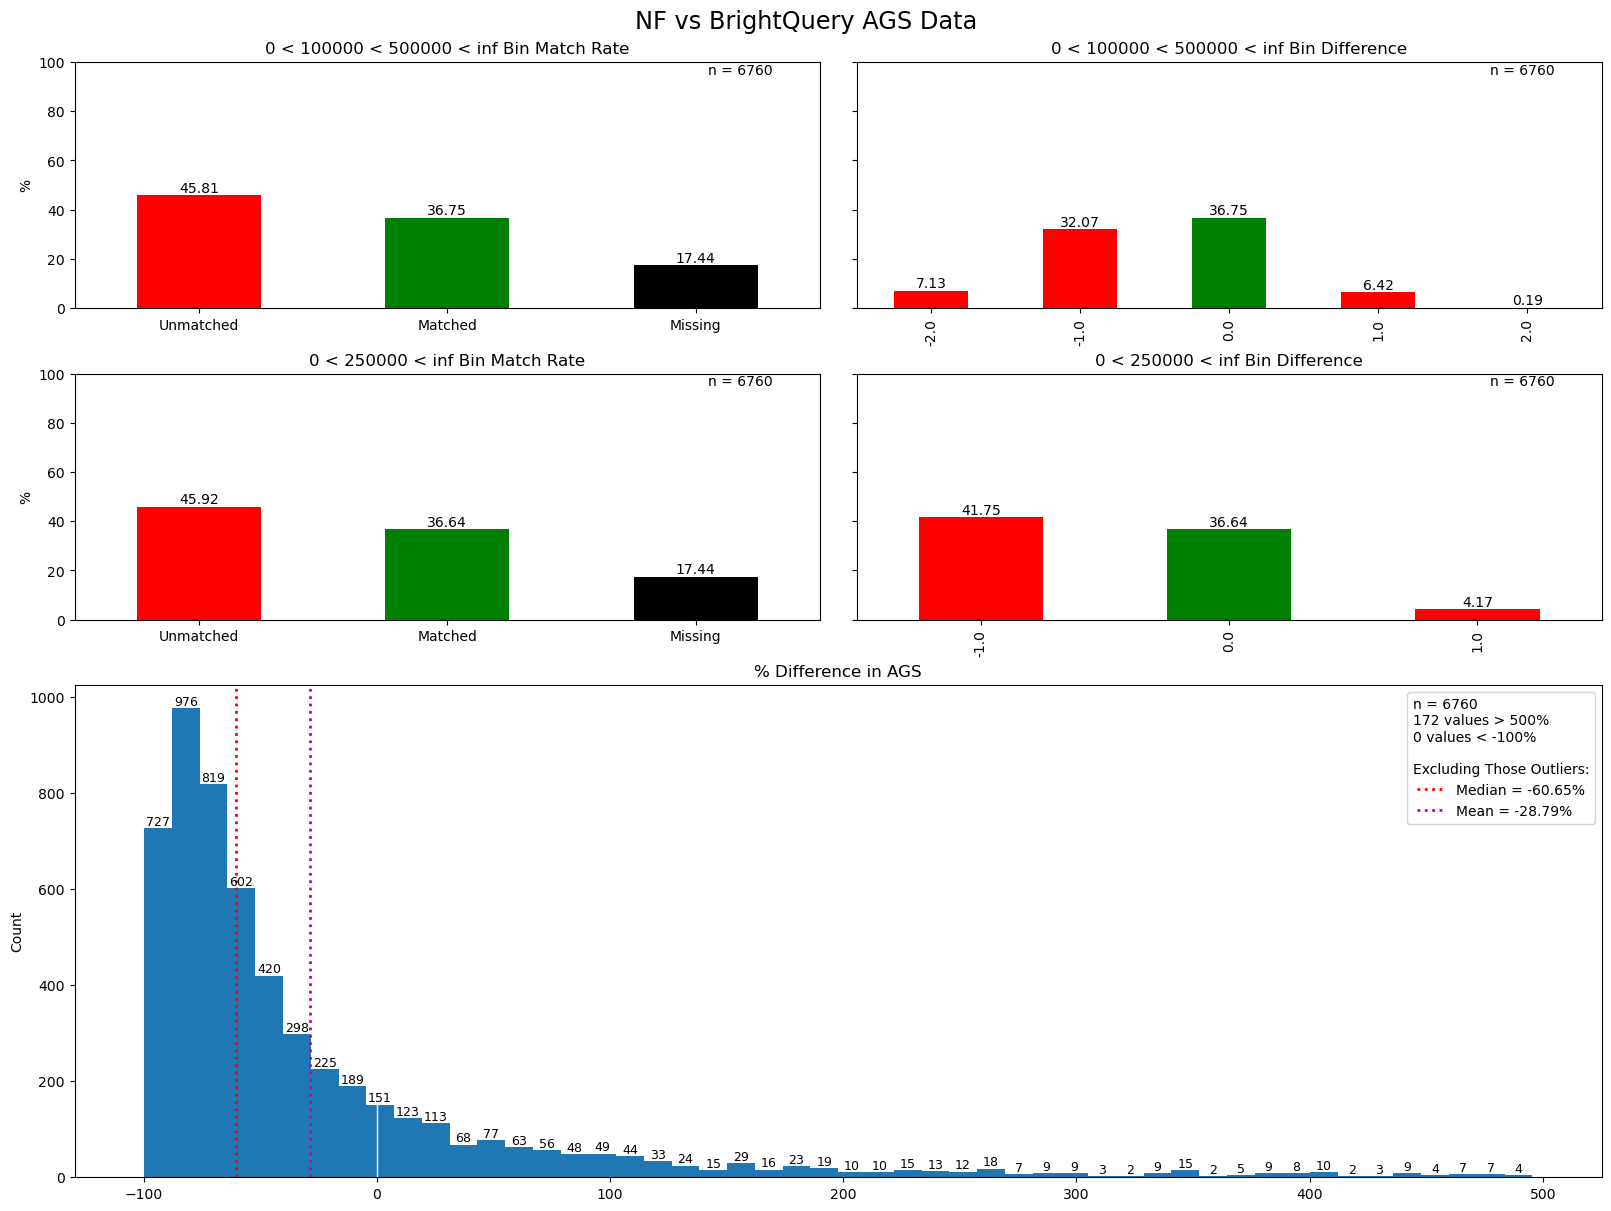

In [33]:
nf_vendor_ags_charts(nf_compdf, ags_cutoffs, alt_ags_cutoffs, vendor)

### Business Start Year

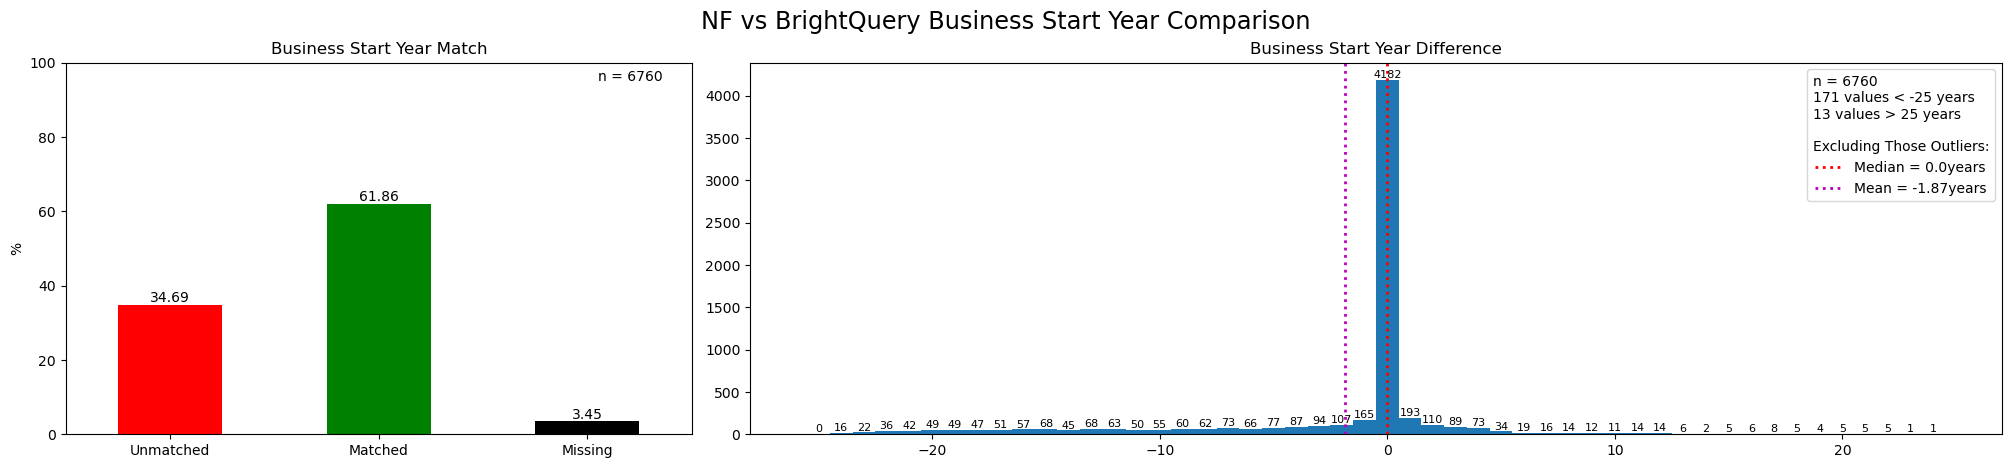

In [34]:
nf_vendor_bsy_charts(nf_compdf, vendor)

### SIC Match Rate

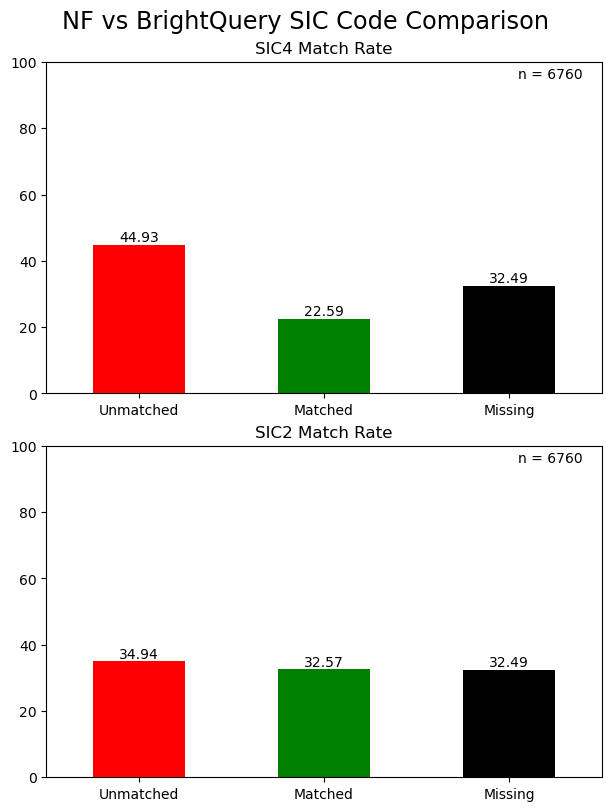

In [35]:
nf_vendor_sic_charts(nf_compdf, vendor)

In [36]:
print('{}% of missing SIC2 codes == 99'.format(round((len(nf_compdf[nf_compdf['nf_sic2'] == '99'])/len(nf_compdf[nf_compdf['nf_vendor_sic2_match'] == 0])) *100, 2)))

9.65% of missing SIC2 codes == 99


## Sumbissions 
### Vendor Report Date within 4 months of NF Mail Date

### AGS Recent

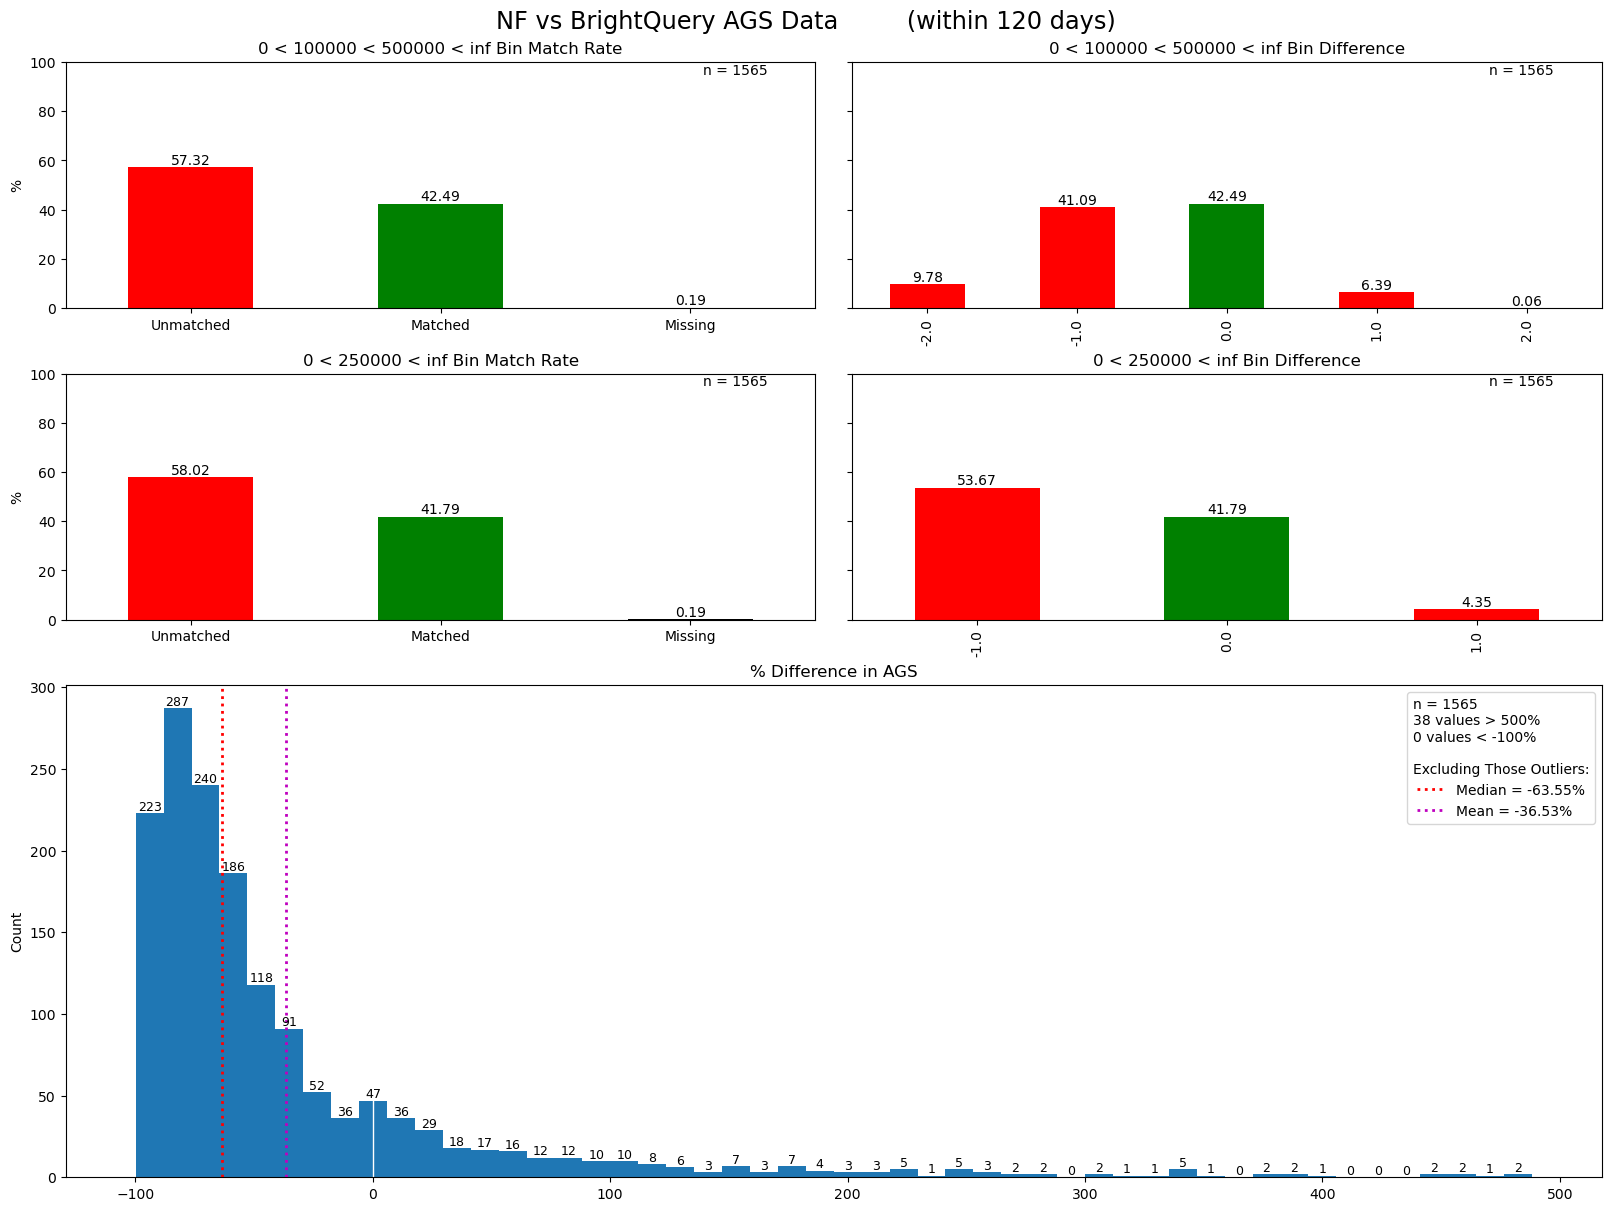

In [37]:
nf_vendor_ags_recent_charts(nf_compdf, vendor, delta_mail_date)

### Business Start Year

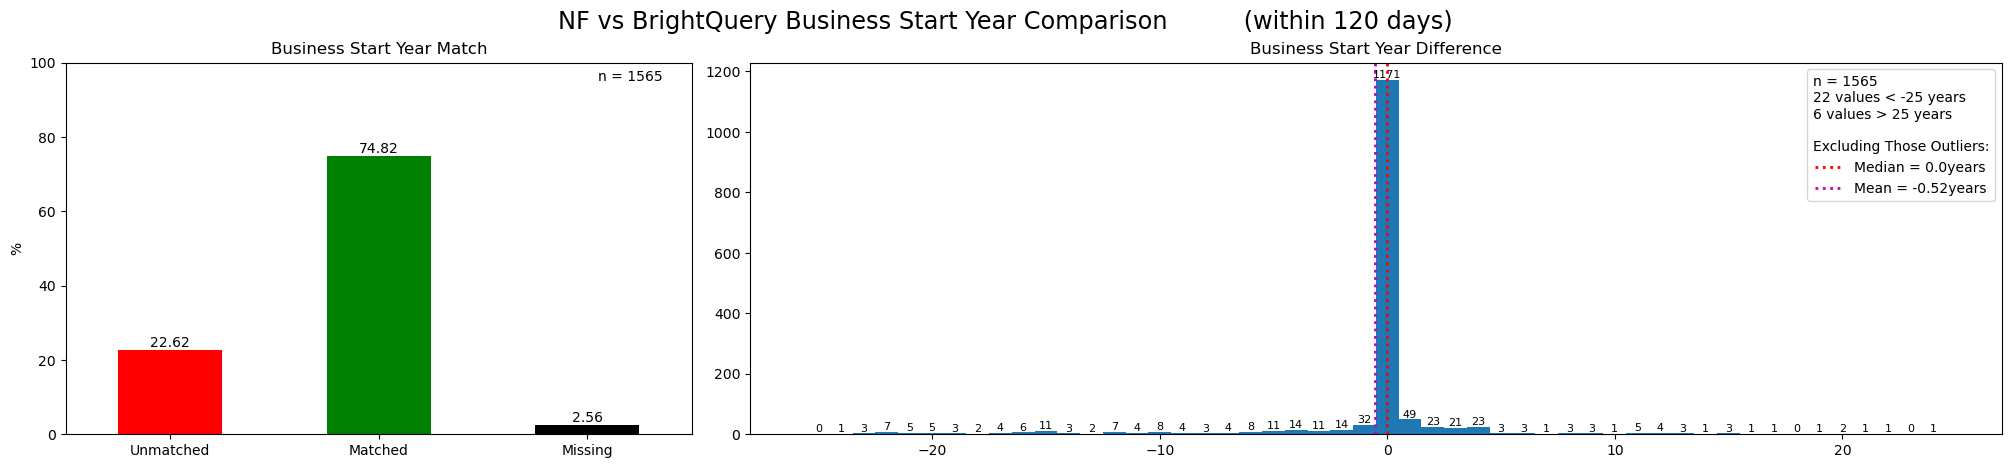

In [38]:
nf_vendor_bsy_recent_charts(nf_compdf, vendor, delta_mail_date)

### SIC Match Rate

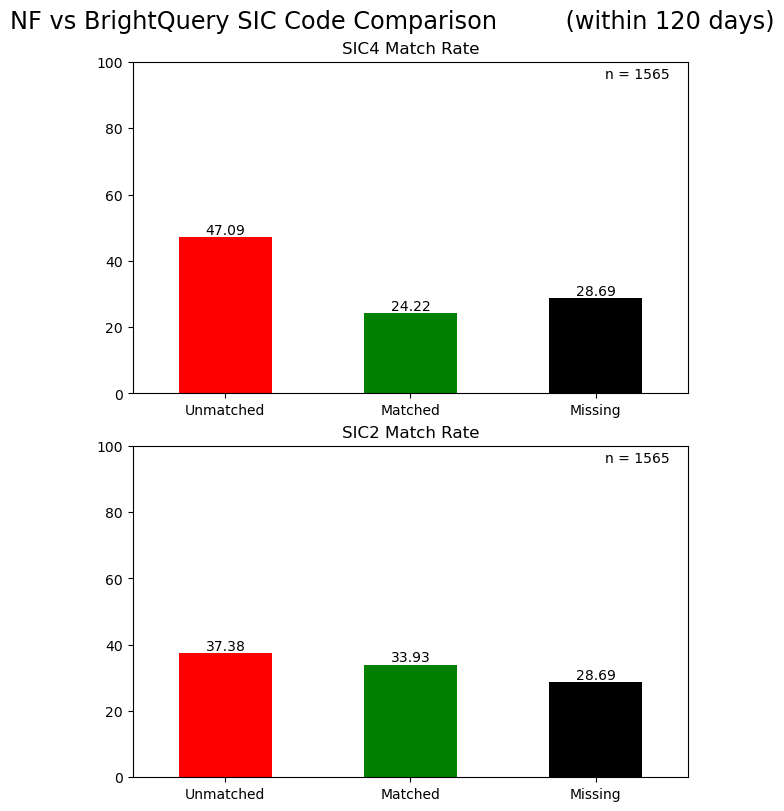

In [39]:
nf_vendor_sic_recent_charts(nf_compdf, vendor, delta_mail_date)

In [40]:
print('{} % of missing SIC2 codes == 99'.format(round((len(dnb_compdf[dnb_compdf['dnb_sic2'] == '99'])/len(dnb_compdf[dnb_compdf['dnb_vendor_sic2_match'] == 0])) *100 , 2)))

30.83 % of missing SIC2 codes == 99


# Dun & Bradstreet vs BrightQuery

### AGS

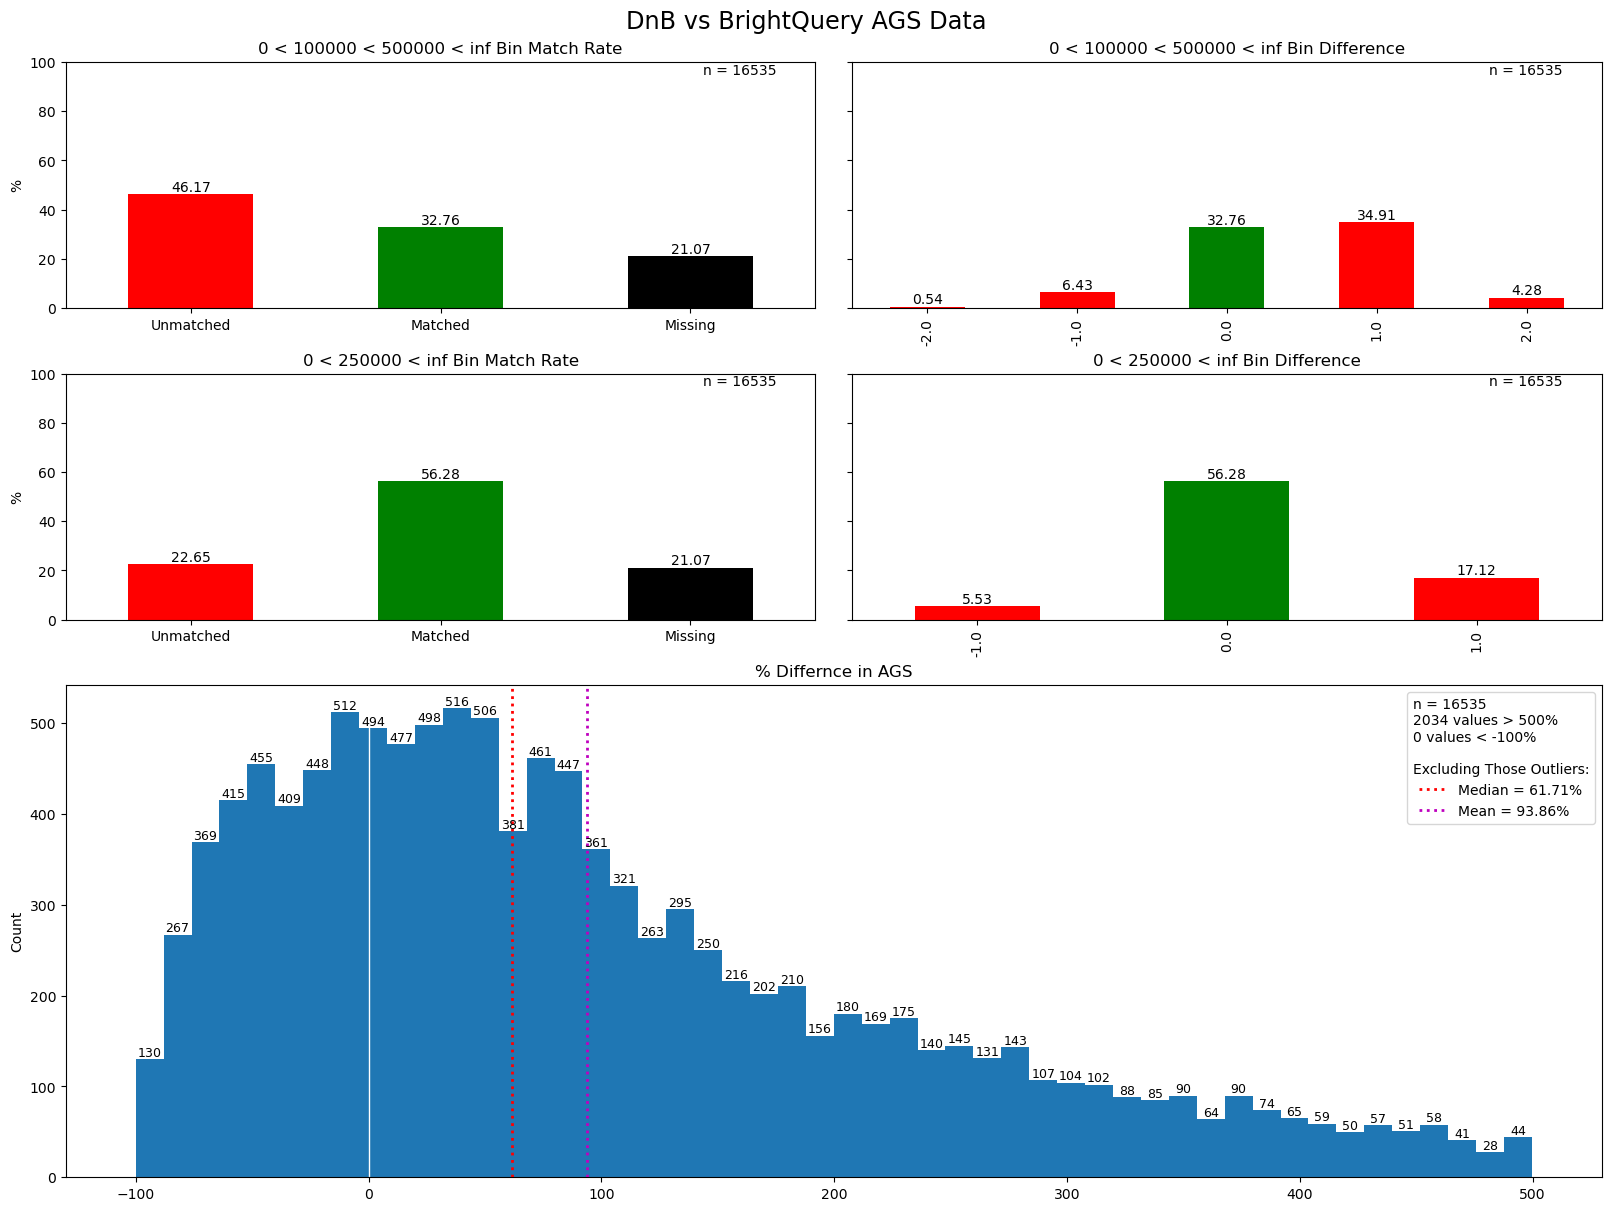

In [41]:
dnb_ven_ags_charts(dnb_compdf, ags_cutoffs, alt_ags_cutoffs,vendor, cutoffs_250)

### Employees

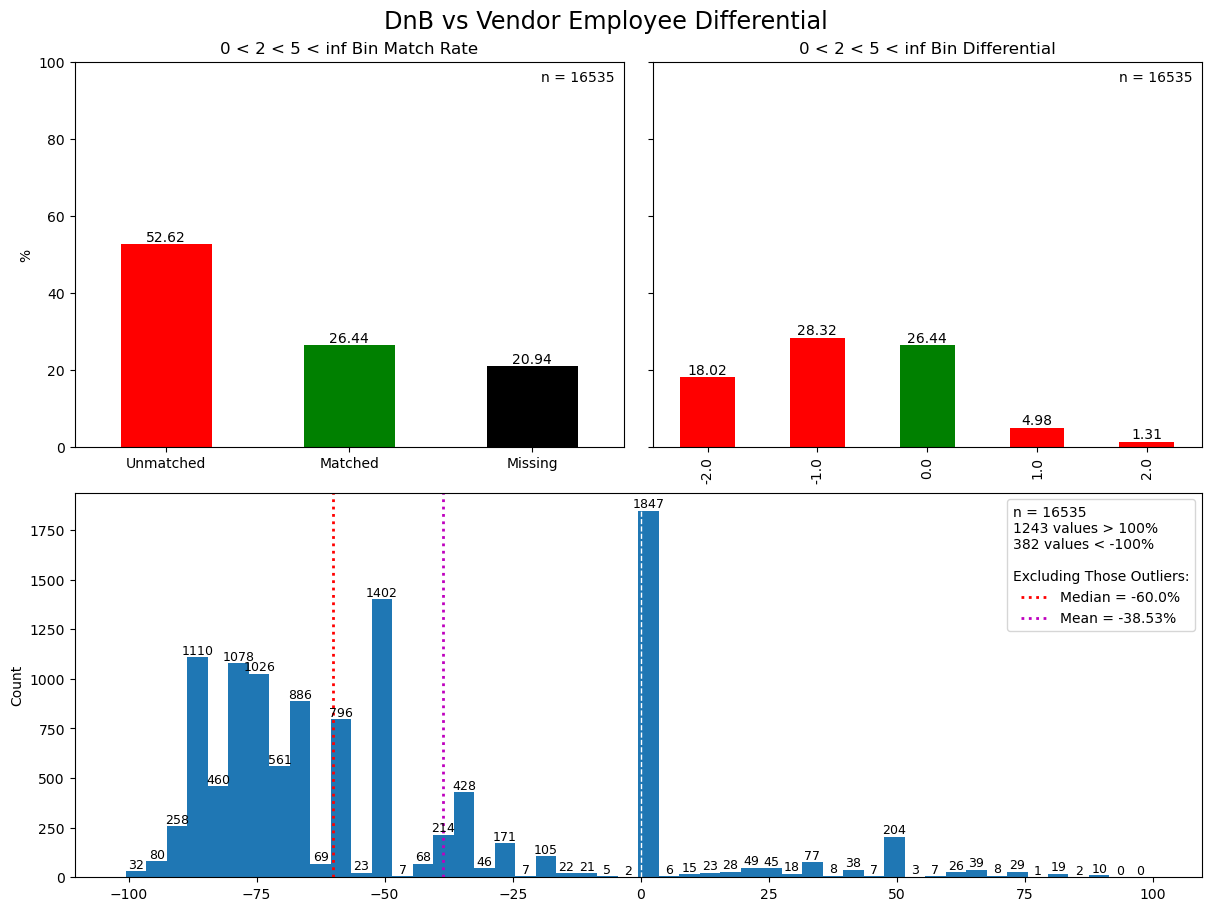

In [42]:
dnb_ven_emp_charts(dnb_compdf, emp_cutoffs)
#cap at -100% into one bin
#output summary: include mean

### Business Start Year

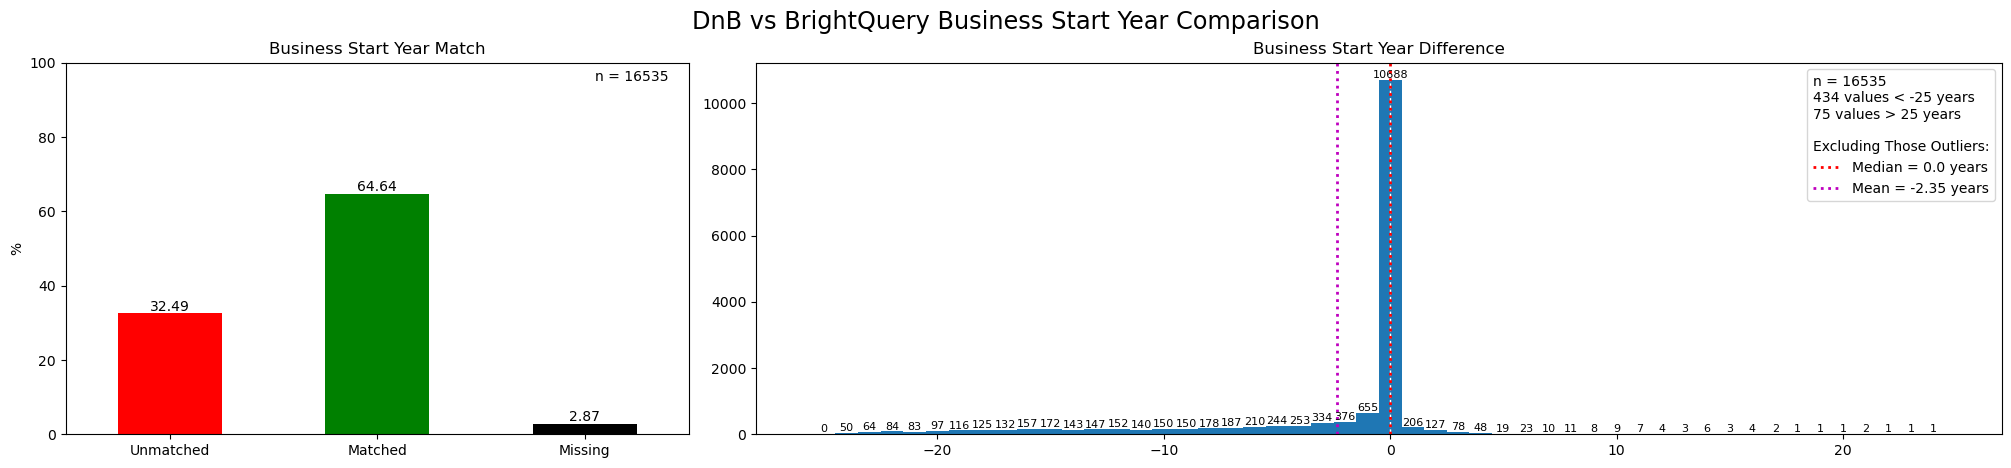

In [43]:
dnb_vendor_bsy_charts(dnb_compdf, vendor)

### SIC Match Rate

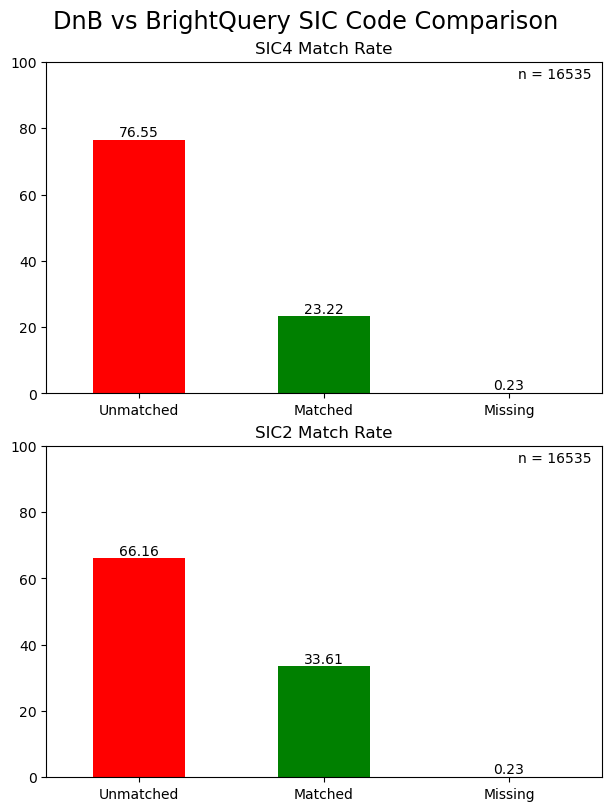

In [44]:
dnb_vendor_sic_charts(dnb_compdf, vendor)

In [45]:
print('{} % of missing SIC2 codes == 99'.format(round((len(dnb_compdf[dnb_compdf['dnb_sic2'] == '99'])/len(dnb_compdf[dnb_compdf['dnb_vendor_sic2_match'] == 0])) *100 , 2)))

30.83 % of missing SIC2 codes == 99


### Company Type Match Rate

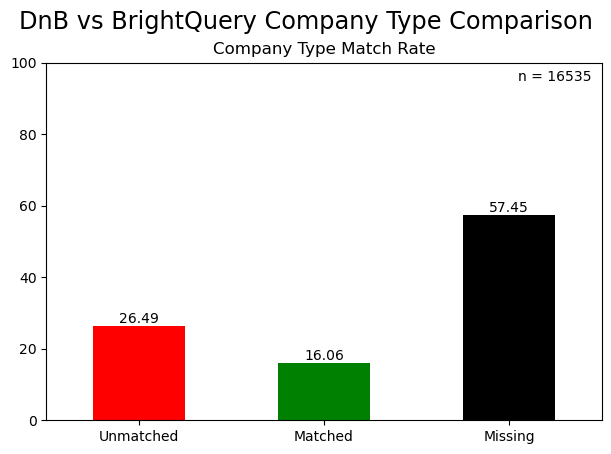

In [46]:
dnb_vendor_company_type_charts(dnb_compdf, vendor)

## we are actually missing a lot of ctypes from DnB

# End

In [47]:
mr_df = pd.read_csv('../BrightQuery_NationalFunding_Extracts_20231122/bq_company_variables_most_recent.csv')
q_df = pd.read_csv('../BrightQuery_NationalFunding_Extracts_20231122/bq_company_variables_time_series_quarterly.csv')
match_df = pd.read_csv('../bq_national_funding_matched.csv')
td_df = pd.read_csv('../../vendor_test_data_internal.csv')

mr_df = mr_df[['bq_id', 'bq_current_employees_plan_mr' ,'bq_revenue_mr', 'bq_report_date_mr']]
q_df = q_df[['bq_id', 'bq_current_employees_plan' ,'bq_revenue', 'bq_year', 'bq_quarter', 'bq_fiscal_quarter_end']]
td_df = td_df[['unique_id' ,'credit_review_ags', 'run_date', 'mail_date']]
match_df = match_df[['unique_id', 'bq_id']]


mr_df['bq_report_date_mr'] = pd.to_datetime(mr_df['bq_report_date_mr'])
q_df['bq_fiscal_quarter_end'] = pd.to_datetime(q_df['bq_fiscal_quarter_end'])
td_df['run_date'] = pd.to_datetime(td_df['run_date'])
td_df['mail_date'] = pd.to_datetime(td_df['mail_date'])

q_df = q_df.sort_values(by=['bq_id', 'bq_fiscal_quarter_end'])
rq_df = q_df.drop_duplicates(subset=['bq_id'], keep='last')
xdf = mr_df.merge(rq_df, on='bq_id')
xdf['diff'] = ((4 * xdf['bq_revenue'] - xdf['bq_revenue_mr']) / xdf['bq_revenue_mr']) * 100
xdf['same_rd_fq_date'] = xdf.apply(lambda x: 1 if x['bq_report_date_mr'] == x['bq_fiscal_quarter_end'] else 0, axis=1)
                                   
mdf = td_df.merge(match_df, on='unique_id')
df = mdf.merge(xdf, on='bq_id')



In [48]:
df['nf_vendor_date_diff'] = df['mail_date'] - df['bq_fiscal_quarter_end']
df['nf_vendor_date_diff'] = pd.to_numeric(df['nf_vendor_date_diff'].dt.days, downcast='integer')

In [49]:
df.head()

,unique_id,credit_review_ags,run_date,mail_date,bq_id,bq_current_employees_plan_mr,bq_revenue_mr,bq_report_date_mr,bq_current_employees_plan,bq_revenue,bq_year,bq_quarter,bq_fiscal_quarter_end,diff,same_rd_fq_date,nf_vendor_date_diff
0,14,NaN,2021-11-01,2022-01-01,100041367697,2,306158.0,NaT,2,74026.0,2023,2,2023-06-30,-3.283925,0,-545
1,40,NaN,2023-03-01,2023-05-01,100001331098,3,345288.0,2023-03-31,3,89879.0,2023,1,2023-03-31,4.120618,1,31
2,43,NaN,2022-03-01,2022-05-01,100001946295,2,175190.0,NaT,2,42698.0,2023,2,2023-06-30,-2.510417,0,-425
3,66,NaN,2023-01-01,2023-03-01,100007986378,19,2327213.0,NaT,19,605900.0,2023,2,2023-06-30,4.141735,0,-121
4,71,NaN,2022-03-01,2022-05-01,100038415683,2,248858.0,NaT,2,60582.0,2023,2,2023-06-30,-2.623986,0,-425


## Contact Points

In [53]:
display(dnb_compdf[dnb_compdf['dnb_vendor_sic2_match'] == 0].groupby(['dnb_sic2']).agg({'unique_id': 'count'}).sort_values(by='unique_id', ascending=False))

,unique_id
dnb_sic2,
99,3373
47,1411
73,981
87,579
17,355
...,...
91,2
97,1
40,1


In [52]:
pip list

Package                       Version
----------------------------- -----------
ansiwrap                      0.8.4
asttokens                     2.0.8
attrs                         22.1.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
black                         22.6.0
bleach                        5.0.1
brotlipy                      0.7.0
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.1.1
click                         8.1.3
colorama                      0.4.6
cramjam                       2.6.2
cryptography                  38.0.2
cycler                        0.11.0
debugpy                       1.6.3
decorator                     5.1.1
defusedxml                    0.7.1
entrypoints                   0.4
et-xmlfile                    1.0.1
executing                     1.1.1
fastjsonschema                2.16.2
fastparquet                   0.0.0
fonttools  